# DTSA 5511 Final Project

## Introduction
This project will attempt to classify music genres using deep learning.  
  
Digital audio files get stored in an MP3 format. This format compresses audio files for better storage and transfer. However, because of this compression we can't use deep learning techniques on the MP3 files themselves. To do analysis, we transform the compressed files into their wave equivalents. Note that some information will be lost during compression, but for our purposes that loss is negligible.  
  
To train our models we will decode the MP3 files into a visual wave representation known as a mel-spectogram. These wave visuals will display time on the x-axis, frequency on the y-axis, and represent amplitude as a color. Given that we now have a visual; we can use variations of computer vision techniques that we are already familiar with.  
  
We will use a basic convolutional neural network (CNN) to start, then try to layer on a long-short term memory (LSTM) component to incorporate the time elements of the wave, and finally, use asymmetric kernels in a CNN architecture.
  
This work can be applied to enhance the listening experience for people using music services. Identifying song genres can introduce new music to users, or help them curate custom playlists.

### Import Libraries

In [48]:
# libraries
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import librosa   # converts mp3s to wave images
import librosa.display
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Dense, Reshape, BatchNormalization, Activation, Bidirectional
from tensorflow.keras import layers, models, regularizers


## The Data
The FMA data can be downloaded from github here: https://github.com/mdeff/fma/. The primary contributed is Michaël Defferrard https://github.com/mdeff  
  
I downloaded the music files (fma_small.zip) and metadata for those files (fma_metadata.zip) to Google Drive for storage. The fma_small file contains the first 30 seconds of 8,000 songs in MP3 format. The songs belong to 8 different genres.  
  
The fma_small.zip file takes up 7.51 GB so I will handle unzipping that file in this notebook.  
  
The metadata file contains 106,574 rows. This is the metadata information for all the songs in the greater mfa dataset. We will only be using a subset of this data, the subset of songs in the mfa_small.zip file. Additionally, the file contains columns for artist, engineer, and producer; date created and published; related websites and information; and crucially, genre. We will only be needing the song id and genre from this dataset. Once we download the music files we can match via id to get the target variables.

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load and unzip the metadata

In [3]:
# unzip the downloaded file
!unzip -q "/content/drive/MyDrive/DTSA5511_Final/fma_metadata/fma_metadata.zip" -d "/content/fma_metadata"

In [4]:
# check that it unzipped
!ls /content/fma_metadata/fma_metadata

checksums     genres.csv	raw_artists.csv   raw_tracks.csv
echonest.csv  not_found.pickle	raw_echonest.csv  README.txt
features.csv  raw_albums.csv	raw_genres.csv	  tracks.csv


In [5]:
tracks = pd.read_csv('/content/fma_metadata/fma_metadata/tracks.csv', index_col=0, header=[0, 1])   # some funny headers in this file

In [6]:
tracks.head()

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                                    <p></p>    6073   
10               4  6                                        NaN   47632   
20               2  4  <p> "spiritual songs" from Nicky Cook</p>    2710   

                        ...       track                         \
         producer tags  ... information interest language_code   
track_id                ...                                      
2             NaN   []  ...         NaN     4656            en   
3             NaN   []  ...         NaN     1470            en   
5             NaN   []  ...         NaN     1933            en   
10            NaN   []  ...         NaN    54881            en   
20            NaN   []  ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

### Load and unzip the music files

In [7]:
!unzip -q "/content/drive/MyDrive/DTSA5511_Final/fma_small/fma_small.zip" -d "/content/fma_small"

In [8]:
!ls /content/fma_small/fma_small

000  012  024  036  048  060  072  084	096  108  120  132  144  checksums
001  013  025  037  049  061  073  085	097  109  121  133  145  README.txt
002  014  026  038  050  062  074  086	098  110  122  134  146
003  015  027  039  051  063  075  087	099  111  123  135  147
004  016  028  040  052  064  076  088	100  112  124  136  148
005  017  029  041  053  065  077  089	101  113  125  137  149
006  018  030  042  054  066  078  090	102  114  126  138  150
007  019  031  043  055  067  079  091	103  115  127  139  151
008  020  032  044  056  068  080  092	104  116  128  140  152
009  021  033  045  057  069  081  093	105  117  129  141  153
010  022  034  046  058  070  082  094	106  118  130  142  154
011  023  035  047  059  071  083  095	107  119  131  143  155


In [9]:
!ls /content/fma_small/fma_small/108

108012.mp3  108155.mp3	108416.mp3  108478.mp3	108528.mp3  108864.mp3
108014.mp3  108230.mp3	108418.mp3  108487.mp3	108529.mp3  108865.mp3
108015.mp3  108290.mp3	108420.mp3  108488.mp3	108530.mp3  108866.mp3
108016.mp3  108297.mp3	108421.mp3  108489.mp3	108531.mp3  108867.mp3
108017.mp3  108298.mp3	108422.mp3  108490.mp3	108532.mp3  108868.mp3
108018.mp3  108299.mp3	108423.mp3  108491.mp3	108533.mp3  108878.mp3
108019.mp3  108300.mp3	108425.mp3  108492.mp3	108745.mp3  108879.mp3
108020.mp3  108301.mp3	108426.mp3  108493.mp3	108774.mp3  108880.mp3
108021.mp3  108302.mp3	108427.mp3  108494.mp3	108799.mp3  108881.mp3
108022.mp3  108303.mp3	108428.mp3  108495.mp3	108808.mp3  108882.mp3
108023.mp3  108304.mp3	108429.mp3  108496.mp3	108809.mp3  108883.mp3
108024.mp3  108305.mp3	108456.mp3  108497.mp3	108812.mp3  108884.mp3
108025.mp3  108306.mp3	108457.mp3  108498.mp3	108836.mp3  108885.mp3
108026.mp3  108307.mp3	108459.mp3  108499.mp3	108837.mp3  108906.mp3
108027.mp3  108308.mp3	108460.mp3 

### Our MP3 files get stored in subfolders of the fma_small file; folders named '000' to '155.' There are a different number of MP3 files in each of these folders.

## Data Exploration and Cleaning

### Extract file IDs
We need to loop through the MP3 file names to get their ids. We can then filter the metadata file to get the targets we need.


In [10]:
# store the file ids
file_ids = []   # initialize the list

for root, dirs, files in os.walk('/content/fma_small/fma_small'):   # start at root, then go through each subfolder
    for file in files:
        if file.endswith('.mp3'):   # only want the mp3 files
            track_id = int(file.replace('.mp3', ''))   # remove the '.mp3' from the file name
            file_ids.append(track_id)


### According to the documentation we should have 8000 files, let's check

In [11]:
# check length
len(file_ids)

8000

### Filter metadata to only the files we have downloaded

In [12]:
# filter metadata
print(f'before filter rows: {tracks.shape}')
tracks = tracks.loc[file_ids]
print(f'after filter rows: {tracks.shape}')


before filter rows: (106574, 52)
after filter rows: (8000, 52)


### Distribution of the target class

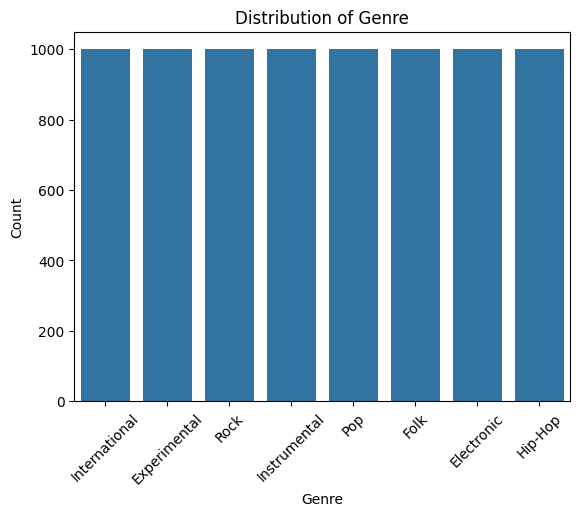

In [13]:
# plot of target class
sns.countplot(
    tracks
    , x = ('track', 'genre_top')   # two levels for the header rows
)

plt.xticks(rotation=45) # tilt x axis
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Distribution of Genre')
plt.show()

This confirms that we have a completely balanced target class like the github repo suggested we would.

### What years are the songs from?
Using data created instead of date released; date released contains some missing values.

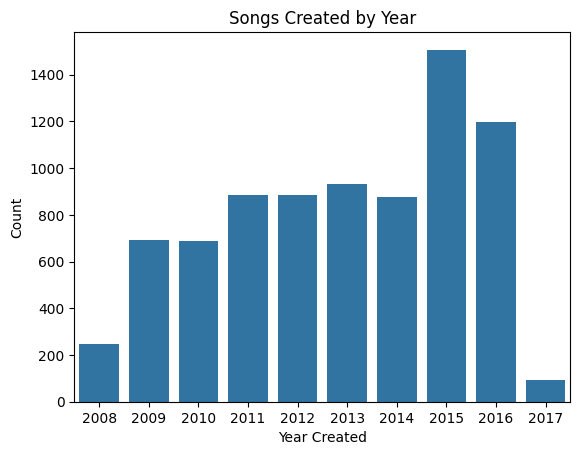

In [14]:
# extract year from created date
tracks[('track', 'date_created')] = pd.to_datetime(tracks[('track', 'date_created')])
tracks[('track', 'year_created')] = tracks[('track', 'date_created')].dt.year

# group by created year
yr_count = tracks.groupby([('track', 'year_created')]).size()

# barchart of songs creted by year
sns.barplot(
    x = yr_count.index
    , y = yr_count.values
)

plt.xlabel('Year Created')
plt.ylabel('Count')
plt.title('Songs Created by Year')
plt.show()

Created year with noticeably more tracks in 2015 and 2016, but nothing too noteworthy here.

### Extracting the spectrogram
Here we convert the MP3 files into the wave representation we need for our computer vision analysis. Let's look at some spectrogram examples by genre.  
  
I used code from the librosa quickstart guide here: https://librosa.org/doc/latest/tutorial.html#quickstart

### The colors below show 0db in yellow, that's actually the loudest part of the sound file, the color scale shows smaller decible values as the color gets more purple then black.

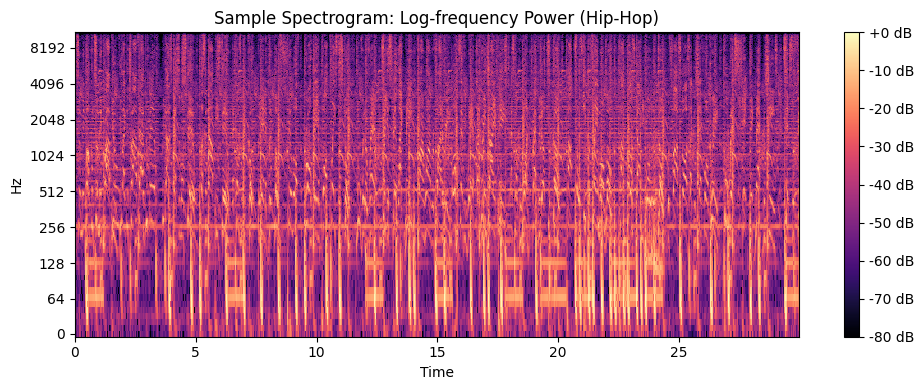

In [15]:
# from the librosa documentation
#    Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
def example_plots(filename, genre):
  #root = '/content/fma_small/fma_small'
  #filename = os.path.join(root, '000', '000002.mp3')


  # convert into the librosa framework
  y, sr = librosa.load(filename)

  hop_length = 512   # think of this as the resolution

  fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

  # Compute the spectrogram (log-scaled)
  D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)), ref=np.max)

  # Display the spectrogram
  img = librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                                 x_axis='time', ax=ax)

  # Add colorbar to indicate dB scale
  plt.colorbar(img, ax=ax, format='%+2.0f dB')

  ax.set(title=f'Sample Spectrogram: Log-frequency Power ({genre})')
  ax.label_outer()
  plt.tight_layout()
  plt.show()

example_plots('/content/fma_small/fma_small/000/000002.mp3', 'Hip-Hop')

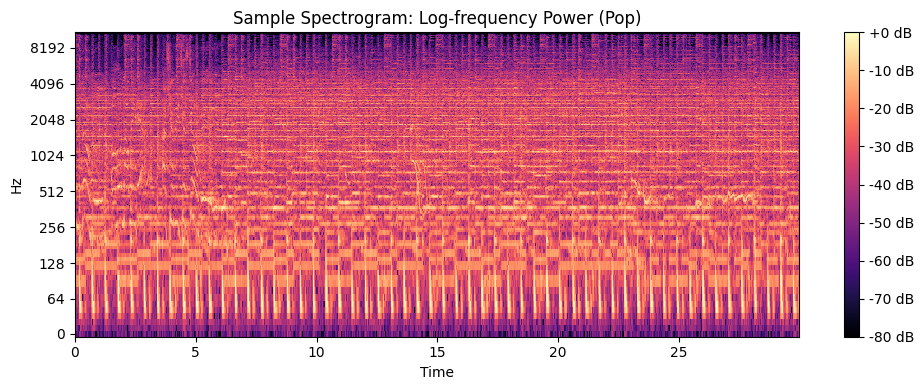

In [16]:
# rock example
example_plots('/content/fma_small/fma_small/000/000010.mp3', 'Pop')

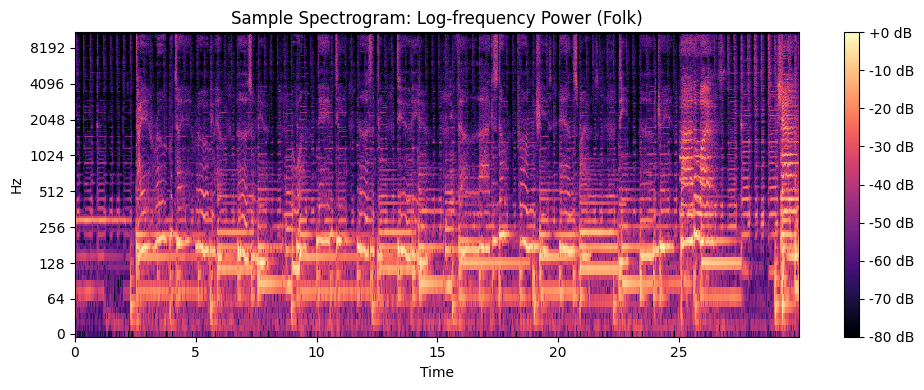

In [17]:
# folk example
example_plots('/content/fma_small/fma_small/000/000140.mp3', 'Folk')

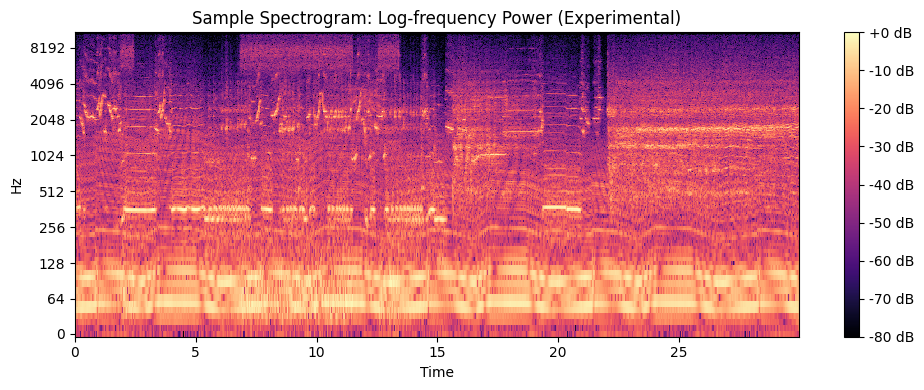

In [18]:
# experimental example
example_plots('/content/fma_small/fma_small/000/000148.mp3', 'Experimental')

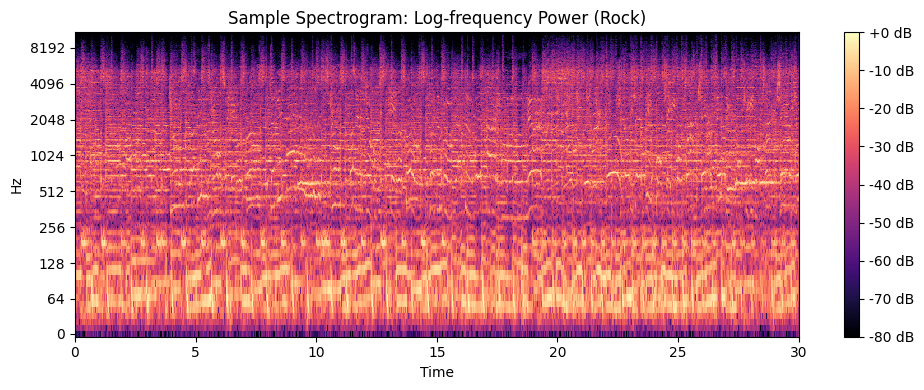

In [19]:
# experimental example
example_plots('/content/fma_small/fma_small/000/000182.mp3', 'Rock')

### The above images clearly show some differences in the spectrograms between the genre classes. Now I'll load all the MP3 files into the appropriate format for model training.
A little bit about how the data is stored and how I processed it for imaging. When we run `y, sr = librosa.load(filename, sr=22050, duration=30)` we convert the mp3 file into `y`, a 1D numpy array that stores the amplitude values $[-1,1]$ over time; and `sr`, the sampling rate, how many samples per second in y.  
With those values together, we can compose the mel spectograms displayed above, these plot the frequency on the y-axis and time on the x-axis. We get here through the sequence  
`mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)`  
`mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)`  
Those two functions from the `librosa` library convert the 1D `y` array into a 128x1291 image with 1 color channel showing the decible value $[-80, 0]$. Again note that the function maps the decible values according to the max amplitude in `y`; so 0 is the highest value.  
Because convolutional neural networks tend to works better on input values in the range $[0,1]$, we transform the values into that range as the last processing step.  

The code cell below shows this process and the input and output dimensions.

In [20]:
# sample processing steps

filename = '/content/fma_small/fma_small/000/000002.mp3'
y, sr = librosa.load(filename, sr=22050, duration=30)

mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
mel_spec_tran = (mel_spec_db + 80) / 80

print(f'y numpy array dim: {y.shape}')
print(f'processed mel-spectrogram shape: {mel_spec_db.shape}')
print(f'random pixel db value: {mel_spec_db[90, 473]}')
print(f'random pixel transformed value: {mel_spec_tran[90, 473]}')

y numpy array dim: (660984,)
processed mel-spectrogram shape: (128, 1291)
random pixel db value: -41.359466552734375
random pixel transformed value: 0.48300665616989136


### Here's a great blog post about mel-spectrograms above:
https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505/

### With the processing steps explained, let's go ahead and load or data

In [21]:
# function for processing
def process_file(filename):
  y, sr = librosa.load(filename, sr=22050, duration=30)               # set sr to 22050 (standard) and enforce time duration to 30s
  mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)   # convert to mel-spectrogram

  # enforce length by padding or cropping
  if mel_spec.shape[1] < 1291:
    pad_width = 1291 - mel_spec.shape[1]
    mel_spec = np.pad(mel_spec, pad_width=((0,0), (0, pad_width)), mode='constant')
  else:
    mel_spec = mel_spec[:, :1291]

  mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)             # change values to db scale
  mel_spec_tran = (mel_spec_db + 80) / 80                             # transform db scale to [0,1]

  # add channel for TensorFlow
  mel_spec_tran = np.expand_dims(mel_spec_tran, axis=-1)              # add an axis so we get (128x1291x1)

  return mel_spec_tran



### Apologies for the large output below, I wanted to make sure the code ran ok

In [58]:
# read in mp3 files and process saving in X
X = []

for root, dirs, files in os.walk('/content/fma_small/fma_small/'):   # start at root, then go through each subfolder
    #for file in tqdm(files):  # used tqdm to track progress, takes about 30 mins
    for file in files:   # rerunning to clean up the output for submission
        if file.endswith('.mp3'):   # only want the mp3 files
          filename = os.path.join(root, file)   # add the root to the filename
          try:                                  # added this section after an error: 108925.mp3': File does not exist or is not a regular file (possibly a pipe?)
            X.append(process_file(filename))
          except:
            print(f'error with {filename}')



/tmp/ipython-input-21-575813159.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=22050, duration=30)               # set sr to 22050 (standard) and enforce time duration to 30s
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


error with /content/fma_small/fma_small/099/099134.mp3


/tmp/ipython-input-21-575813159.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=22050, duration=30)               # set sr to 22050 (standard) and enforce time duration to 30s
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-21-575813159.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=22050, duration=30)               # set sr to 22050 (standard) and enforce time duration to 30s
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp

error with /content/fma_small/fma_small/108/108925.mp3


/tmp/ipython-input-21-575813159.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filename, sr=22050, duration=30)               # set sr to 22050 (standard) and enforce time duration to 30s
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


error with /content/fma_small/fma_small/133/133297.mp3


In [23]:
print(f'files processed: {len(X)}')
print(f'sample X shape: {X[37].shape}')

files processed: 7997
sample X shape: (128, 1291, 1)


## Modeling
We used the Librosa library to represent our audio files as images, so now we can utilize some deep learning tasks suited for computer-vision tasks.  Convolutional Neural Networks (CNN) can effectively classify images, so we'll start there. After we build a base CNN model, we will tune the performance to see if we can make it better.  
  
Next, we'll try a new architecture, a CNN layered with a Recurrent Neural Network (RNN). RNNs do well at classifying sequential data; so, it makes sense for the mel spectrograms, which combine 2D and temporal elements. Again we will tune the hyperparameters to improve our model.  
  
Finally, I tried another variation on the CNN architecture. Instead of using square kernels (n x n), I used asymmetric ones (n x m); where $n \neq m$ . I hope this will pick up frequency features and time features independent of one another.

### Train, validation, and test sets
Note that the cleaning/processing step couldn't handle three files so we're left with 7,997 files for training and testing.  
  
Thankfully I printed out the output during the processing step. I can see what files showed an error and can remove them from the labels manually.

In [24]:
# turn X into an array
X = np.array(X)

# identify the file errors
file_errors = [108925, 133297, 99134]

# remove the error files from label set
y = tracks.drop(file_errors)

# get only target column from y
y = y[('track', 'genre_top')]

# need to one-hot the y set
y = pd.get_dummies(y)
y = y.values

# check dimensions
print(f'X dim: {X.shape}')
print(f'y dim: {y.shape}')


X dim: (7997, 128, 1291, 1)
y dim: (7997, 8)


In [25]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20250620)

# look at teh shapes to make sure we got it right
print(f'X_train dim: {X_train.shape}')
print(f'y_train dim: {y_train.shape}')
print(f'X_test dim: {X_test.shape}')
print(f'y_test dim: {y_test.shape}')


X_train dim: (7197, 128, 1291, 1)
y_train dim: (7197, 8)
X_test dim: (800, 128, 1291, 1)
y_test dim: (800, 8)


### Our first model will be a simple CNN setup
Code modified from here: https://keras.io/examples/vision/mnist_convnet/

I start with larger kernels to try and capture more global trends in genres. I then use a pooling layer to reduce the dimensionality. I repeat this three times with decreasing kerenl size as I go. The idea being that we start with general trends and then to to find filters for finer details.  
  
For the activation functions I chose to use PReLU. It avoids the dying neuron problem and can help stabalize training by learning the alpha parameter. This does add complexity as the alpha parameter needs to be learned and updated.  
  
To help avoid overfitting, I added a regularization dropout layer after each cycle.  
  
This model uses a softmax activation for the output layer as we're trying to pick the best genre out of the eight possible choices.


In [57]:
# Model / data parameters
num_classes = y_train.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2], 1)


cnn_a = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape)
        # first cycle
        , layers.Conv2D(32, kernel_size=(7, 7), padding = 'same')   # start with large kernel to capture more general trends
        , layers.PReLU()
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.3)

        # second cycle
        , layers.Conv2D(64, kernel_size=(5, 5), padding = 'same')   # decrease kernel to find more fine detail
        , layers.PReLU()
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.3)

        # third cycle
        , layers.Conv2D(128, kernel_size=(3, 3), padding = 'same')   # decrease kernel to find more fine detail
        , layers.PReLU()
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.3)

        # output layers
        , layers.Flatten()
        , layers.Dropout(0.5)
        , layers.Dense(num_classes, activation="softmax")
    ]
)

cnn_a.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 1291, 32)  │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 128, 1291, 32)  │     5,287,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 645, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 645, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 645, 64)    │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 64, 645, 64)    │     2,641,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 322, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 322, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 322, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 32, 322, 128)   │     1,318,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 161, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 161, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 329728)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 329728)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │     2,637,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,013,320 (45.83 MB)

 Trainable params: 12,013,320 (45.83 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# set training hyperparameters
batch_size = 64
epochs = 20

# set optimizer
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss"
    , patience = 4                    # stop if val loss doesn't improve after 4 epochs
    , restore_best_weights = True
)

# compile
cnn_a.compile(
    loss="categorical_crossentropy"
    , optimizer=opt
    , metrics=["accuracy"]
)

# fit
cnn_a_hist = cnn_a.fit(
    X_train
    , y_train
    , batch_size = batch_size
    , epochs = epochs
    , validation_split = 0.2
)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 80s 596ms/step - accuracy: 0.1617 - loss: 2.3628 - val_accuracy: 0.2458 - val_loss: 1.9071
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - accuracy: 0.2874 - loss: 1.8544 - val_accuracy: 0.3556 - val_loss: 1.7277
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step - accuracy: 0.3706 - loss: 1.7211 - val_accuracy: 0.3646 - val_loss: 1.7038
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 291ms/step - accuracy: 0.4263 - loss: 1.5630 - val_accuracy: 0.2944 - val_loss: 1.8223
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 292ms/step - accuracy: 0.4328 - loss: 1.5767 - val_accuracy: 0.4007 - val_loss: 1.6291
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 291ms/step - accuracy: 0.5261 - loss: 1.3610 - val_accuracy: 0.4451 - val_loss: 1.5757
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 292ms/step - accuracy: 0.5882 - loss: 1.2061 - val_accuracy: 0.4306 - val_loss: 1.6463
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 295ms/step - accuracy: 0.6178 - loss: 1.1110 - val_accu

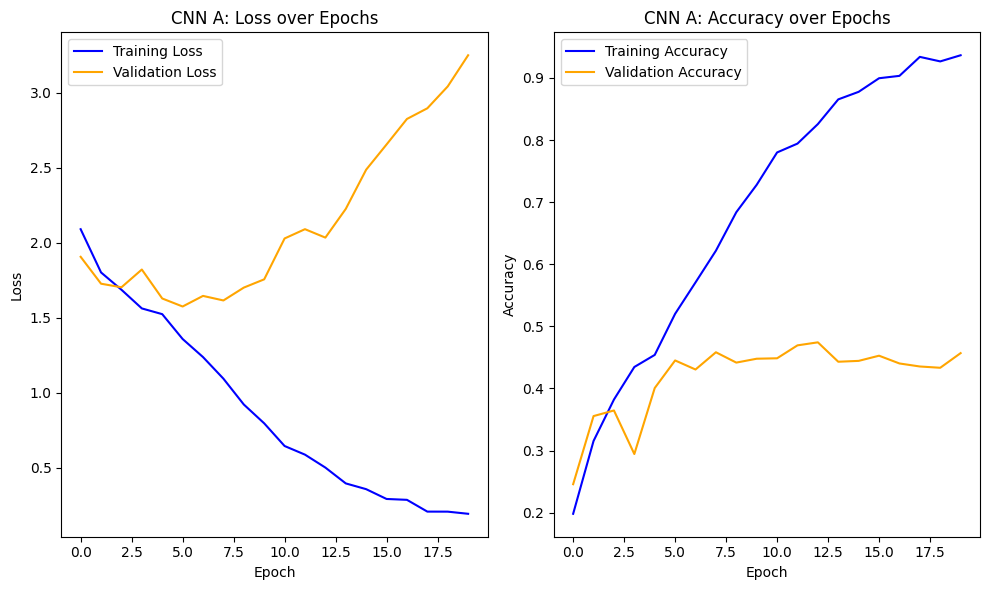

In [59]:
# plot loss and accuracy for training and val sets
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# loss plot
axs[0].plot(cnn_a_hist.history['loss'], label='Training Loss', color='blue')
axs[0].plot(cnn_a_hist.history['val_loss'], label='Validation Loss', color='orange')
axs[0].set_title('CNN A: Loss over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# acc plot
axs[1].plot(cnn_a_hist.history['accuracy'], label='Training Accuracy', color='blue')
axs[1].plot(cnn_a_hist.history['val_accuracy'], label='Validation Accuracy', color='orange')
axs[1].set_title('CNN A: Accuracy over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

I would say that this model doesn't do very well. I think we see a pretty classic overfitting curve.  I also forgot to enable the early stopping-- I will do that for the remaining models.
  
For CNN model B, I will increase the dropout rate and change to a leaky relu to see if we can improve our validation loss and accuracy.

In [63]:
# cnn B
num_classes = y_train.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2], 1)


cnn_b = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape)
        # first cycle
        , layers.Conv2D(32, kernel_size=(7, 7), padding = 'same')   # start with large kernel to capture more general trends
        , layers.LeakyReLU()                      # changed to Leaky Relu
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.4)                     # increased dropout to 0.4

        # second cycle
        , layers.Conv2D(64, kernel_size=(5, 5), padding = 'same')   # decrease kernel to find more fine detail
        , layers.LeakyReLU()                      # changed to Leaky Relu
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.4)                     # increased dropout to 0.4

        # third cycle
        , layers.Conv2D(128, kernel_size=(3, 3), padding = 'same')   # decrease kernel to find more fine detail
        , layers.LeakyReLU()                      # changed to Leaky Relu
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.4)                     # increased dropout to 0.4

        # output layers
        , layers.Flatten()
        , layers.Dropout(0.5)
        , layers.Dense(num_classes, activation="softmax")
    ]
)

cnn_b.summary()

# set training hyperparameters
batch_size = 64
epochs = 20

# set optimizer
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss"
    , patience = 4                    # stop if val loss doesn't improve after 4 epochs
    , restore_best_weights = True
)

# compile
cnn_b.compile(
    loss="categorical_crossentropy"
    , optimizer=opt
    , metrics=["accuracy"]
)

# fit
cnn_b_hist = cnn_b.fit(
    X_train
    , y_train
    , batch_size = batch_size
    , epochs = epochs
    , validation_split = 0.2
    , callbacks = [early_stopping]   # forgot to add early stopping last time
)



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 128, 1291, 32)  │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128, 1291, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 645, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 645, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 645, 64)    │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64, 645, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 322, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 322, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 322, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 322, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 161, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 161, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 329728)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 329728)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │     2,637,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,764,552 (10.55 MB)

 Trainable params: 2,764,552 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 34s 320ms/step - accuracy: 0.1945 - loss: 3.0157 - val_accuracy: 0.1944 - val_loss: 1.9435
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 267ms/step - accuracy: 0.3592 - loss: 1.7336 - val_accuracy: 0.1847 - val_loss: 2.0048
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - accuracy: 0.4485 - loss: 1.5461 - val_accuracy: 0.4194 - val_loss: 1.6242
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - accuracy: 0.5262 - loss: 1.3535 - val_accuracy: 0.4139 - val_loss: 1.6392
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - accuracy: 0.6053 - loss: 1.1523 - val_accuracy: 0.4076 - val_loss: 1.7413
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - accuracy: 0.6699 - loss: 0.9525 - val_accuracy: 0.4076 - val_loss: 1.7850
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - accuracy: 0.7600 - loss: 0.6888 - val_accuracy: 0.4097 - val_loss: 2.0421


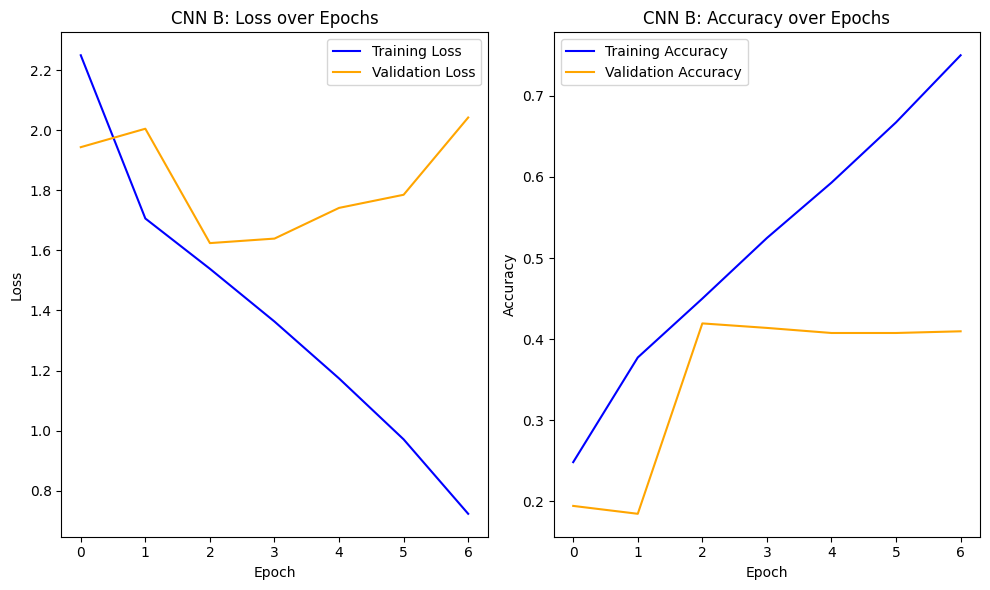

In [64]:
# plot loss and accuracy for training and val sets
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# loss plot
axs[0].plot(cnn_b_hist.history['loss'], label='Training Loss', color='blue')
axs[0].plot(cnn_b_hist.history['val_loss'], label='Validation Loss', color='orange')
axs[0].set_title('CNN B: Loss over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# acc plot
axs[1].plot(cnn_b_hist.history['accuracy'], label='Training Accuracy', color='blue')
axs[1].plot(cnn_b_hist.history['val_accuracy'], label='Validation Accuracy', color='orange')
axs[1].set_title('CNN B: Accuracy over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

Again, I sense a lot of overfitting. Let's try tuning this architecture one more time. We might need to move on to a more sophisticated setup.  
  
I will add regularization and decrease the number of filters on this model to see if we can improve the over fitting problem.

In [28]:
# cnn C
num_classes = y_train.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2], 1)


cnn_c = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape)
        # first cycle
        , layers.Conv2D(32, kernel_size=(7, 7), kernel_regularizer = regularizers.l2(1e-4), padding= 'same')   # added regularizer
        , layers.LeakyReLU()                      # changed to LeakyRelu
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.3)

        # second cycle
        , layers.Conv2D(64, kernel_size=(5, 5), kernel_regularizer = regularizers.l2(1e-4), padding= 'same')   # added regularizer
        , layers.LeakyReLU()                      # changed to LeakyRelu
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.3)

        # third cycle
        , layers.Conv2D(128, kernel_size=(3, 3), kernel_regularizer = regularizers.l2(1e-4), padding= 'same')   # added regularizer
        , layers.LeakyReLU()                      # changed to LeakyRelu
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.3)

        # output layers
        , layers.Flatten()
        , layers.Dropout(0.5)
        , layers.Dense(num_classes, activation="softmax")
    ]
)

cnn_c.summary()

# set training hyperparameters
batch_size = 64
epochs = 60

# set optimizer
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss"
    , patience = 4                    # stop if val loss doesn't improve after 4 epochs
    , restore_best_weights = True
)

# compile
cnn_c.compile(
    loss="categorical_crossentropy"
    , optimizer=opt
    , metrics=["accuracy"]
)

# fit
cnn_c_hist = cnn_c.fit(
    X_train
    , y_train
    , batch_size = batch_size
    , epochs = epochs
    , validation_split = 0.2
    , callbacks = [early_stopping]
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 1291, 32)  │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 1291, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 645, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 645, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 645, 64)    │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 645, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 322, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 322, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 322, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 322, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 161, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 161, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 329728)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 329728)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │     2,637,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,764,552 (10.55 MB)

 Trainable params: 2,764,552 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 79s 582ms/step - accuracy: 0.1864 - loss: 2.0807 - val_accuracy: 0.2313 - val_loss: 1.9749
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - accuracy: 0.3089 - loss: 1.8598 - val_accuracy: 0.2944 - val_loss: 1.8591
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 272ms/step - accuracy: 0.3850 - loss: 1.7125 - val_accuracy: 0.3861 - val_loss: 1.6999
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 272ms/step - accuracy: 0.4236 - loss: 1.6329 - val_accuracy: 0.3806 - val_loss: 1.6714
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 272ms/step - accuracy: 0.4524 - loss: 1.5436 - val_accuracy: 0.4319 - val_loss: 1.6059
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - accuracy: 0.4913 - loss: 1.4702 - val_accuracy: 0.4368 - val_loss: 1.5503
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - accuracy: 0.5195 - loss: 1.3904 - val_accuracy: 0.4444 - val_loss: 1.5635
Epoch 8/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - accuracy: 0.5417 - loss: 1.3292 - val_accu

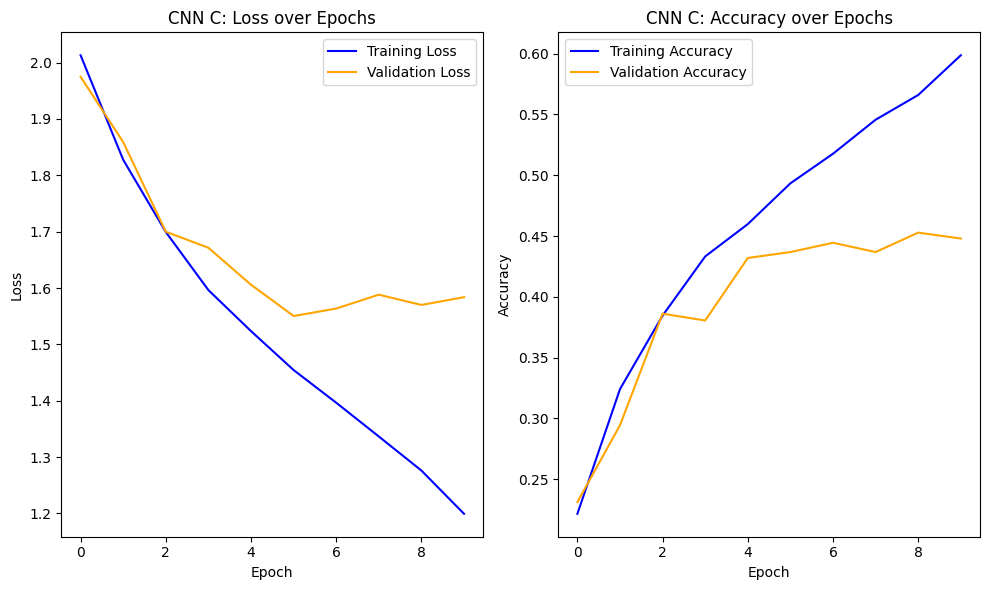

In [29]:
# plot loss and accuracy for training and val sets
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# loss plot
axs[0].plot(cnn_c_hist.history['loss'], label='Training Loss', color='blue')
axs[0].plot(cnn_c_hist.history['val_loss'], label='Validation Loss', color='orange')
axs[0].set_title('CNN C: Loss over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# acc plot
axs[1].plot(cnn_c_hist.history['accuracy'], label='Training Accuracy', color='blue')
axs[1].plot(cnn_c_hist.history['val_accuracy'], label='Validation Accuracy', color='orange')
axs[1].set_title('CNN C: Accuracy over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

Maybe a little better, but I think time to move on and see if we can do better.

### Hybrid CNN-RNN Model
Let's try combining the advantages of both the CNN models and the RNN models. CNN models excel at 2D data and RNN models excel when modeling data over time. The sound images we created are essentially 2D representations of sound over time.

Let's start simple this time. Before I think I started off too complex and ran into overfitting early.

In [72]:
# hybrid cnn-rnn a
num_classes = y_train.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2], 1)


hyb_a = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape)
        # first cnn cycle
        , layers.Conv2D(32, kernel_size=(3, 3), kernel_regularizer = regularizers.l2(1e-4), padding = 'same')
        , layers.LeakyReLU()
        #, layers.MaxPooling2D(pool_size=(2, 2))
        #, layers.Dropout(0.3)
        , layers.BatchNormalization()

        # flatten frequency and channel dimensions, preserve time
        # had ChatGPT help me with this part
        , layers.Reshape((645, -1))

        # first rnn layer
        , layers.LSTM(64, return_sequences = False)   # only care about the last output
        , layers.Dropout(0.4)

        # output layers
        # , layers.Flatten() # already flat
        # , layers.Dropout(0.5)
        , layers.Dense(num_classes, activation="softmax")
    ]
)

hyb_a.summary()

# set training hyperparameters
batch_size = 64
epochs = 60

# set optimizer
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss"
    , patience = 4                    # stop if val loss doesn't improve after 4 epochs
    , restore_best_weights = True
)

# compile
hyb_a.compile(
    loss="categorical_crossentropy"
    , optimizer=opt
    , metrics=["accuracy"]
)

# fit
hyb_a_hist = hyb_a.fit(
    X_train
    , y_train
    , batch_size = batch_size
    , epochs = epochs
    , validation_split = 0.2
    , callbacks = [early_stopping]
)





Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 128, 1291, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 128, 1291, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 645, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64, 645, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 645, 2048)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541,768 (2.07 MB)

 Trainable params: 541,768 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 211ms/step - accuracy: 0.2060 - loss: 2.0096 - val_accuracy: 0.2451 - val_loss: 1.9348
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.2707 - loss: 1.9101 - val_accuracy: 0.2764 - val_loss: 1.8818
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.2824 - loss: 1.8724 - val_accuracy: 0.3042 - val_loss: 1.8347
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.3065 - loss: 1.8473 - val_accuracy: 0.3097 - val_loss: 1.8248
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.2985 - loss: 1.8301 - val_accuracy: 0.3250 - val_loss: 1.8078
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.3238 - loss: 1.8255 - val_accuracy: 0.3118 - val_loss: 1.8197
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - accuracy: 0.3264 - loss: 1.8198 - val_accuracy: 0.3167 - val_loss: 1.8270
Epoch 8/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.3237 - loss: 1.8129 - val_accu

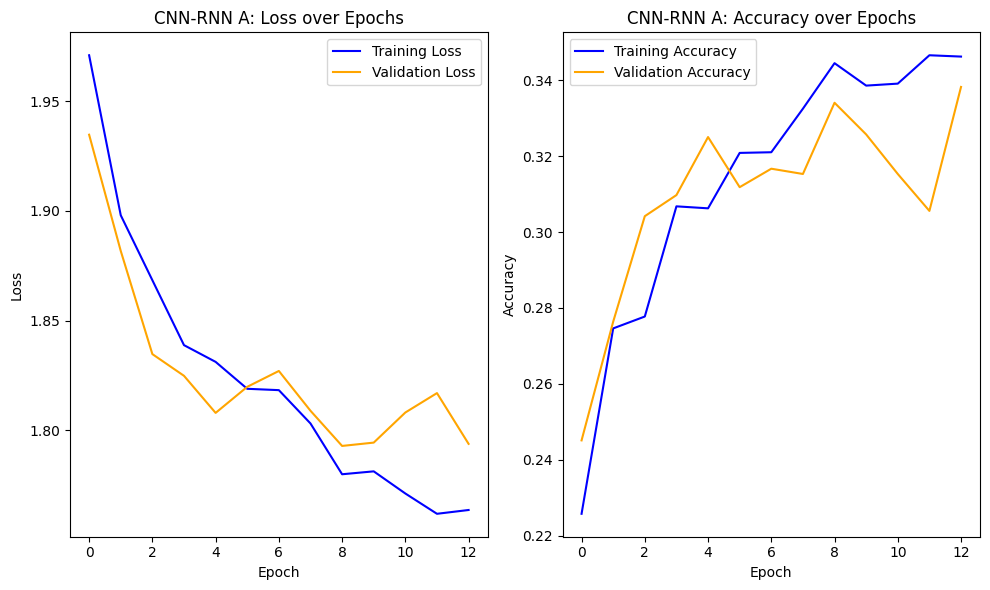

In [73]:
# plot loss and accuracy for training and val sets
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# loss plot
axs[0].plot(hyb_a_hist.history['loss'], label='Training Loss', color='blue')
axs[0].plot(hyb_a_hist.history['val_loss'], label='Validation Loss', color='orange')
axs[0].set_title('CNN-RNN A: Loss over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# acc plot
axs[1].plot(hyb_a_hist.history['accuracy'], label='Training Accuracy', color='blue')
axs[1].plot(hyb_a_hist.history['val_accuracy'], label='Validation Accuracy', color='orange')
axs[1].set_title('CNN-RNN A: Accuracy over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

This first result is a little discouraging, the training accuracy didn't get that high. We'll tweak the architecture and hyperparameters to see if we can improve. It doesn't seem to be learning well so I increase the complexity.
  
For the next model let's increase filters and LSTM layers as well.

In [33]:
# hybrid cnn-rnn b
num_classes = y_train.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2], 1)


hyb_b = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape)
        # first cnn cycle
        , layers.Conv2D(64, kernel_size=(5, 5), kernel_regularizer = regularizers.l2(1e-5), padding = 'same')
        , layers.LeakyReLU()
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.1)

        # second cnn cycle
        , layers.Conv2D(128, kernel_size=(3, 3), kernel_regularizer = regularizers.l2(1e-5), padding = 'same')
        , layers.LeakyReLU()
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.1)

        # flatten frequency and channel dimensions, preserve time
        # had ChatGPT help me with this part
        , layers.Reshape((322, -1))

        # rnn layers
        , layers.LSTM(32, return_sequences = True)
        , layers.LSTM(16, return_sequences = False)   # only care about the last output
        , layers.Dropout(0.1)

        # output layers
        , layers.Dense(num_classes, activation="softmax")
    ]
)

hyb_b.summary()

# set training hyperparameters
batch_size = 64
epochs = 60

# set optimizer
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)

# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss"
    , patience = 6                    # stop if val loss doesn't improve after 6 epochs
    , restore_best_weights = True
)

# compile
hyb_b.compile(
    loss="categorical_crossentropy"
    , optimizer=opt
    , metrics=["accuracy"]
)

# fit
hyb_b_hist = hyb_b.fit(
    X_train
    , y_train
    , batch_size = batch_size
    , epochs = epochs
    , validation_split = 0.2
    , callbacks = [early_stopping]
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 128, 1291, 64)  │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128, 1291, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 645, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 645, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 645, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 64, 645, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 322, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 322, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 322, 4096)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 322, 32)        │       528,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 607,304 (2.32 MB)

 Trainable params: 607,304 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 77s 694ms/step - accuracy: 0.1777 - loss: 2.0318 - val_accuracy: 0.2708 - val_loss: 1.9296
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 517ms/step - accuracy: 0.2606 - loss: 1.9159 - val_accuracy: 0.2701 - val_loss: 1.8796
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 517ms/step - accuracy: 0.2985 - loss: 1.8655 - val_accuracy: 0.3063 - val_loss: 1.8429
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 517ms/step - accuracy: 0.2897 - loss: 1.8606 - val_accuracy: 0.3042 - val_loss: 1.8423
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 517ms/step - accuracy: 0.3169 - loss: 1.8261 - val_accuracy: 0.3104 - val_loss: 1.8049
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 516ms/step - accuracy: 0.3159 - loss: 1.8112 - val_accuracy: 0.3056 - val_loss: 1.8104
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 516ms/step - accuracy: 0.3338 - loss: 1.7996 - val_accuracy: 0.3021 - val_loss: 1.8040
Epoch 8/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 516ms/step - accuracy: 0.3296 - loss: 1.7873 - val_accu

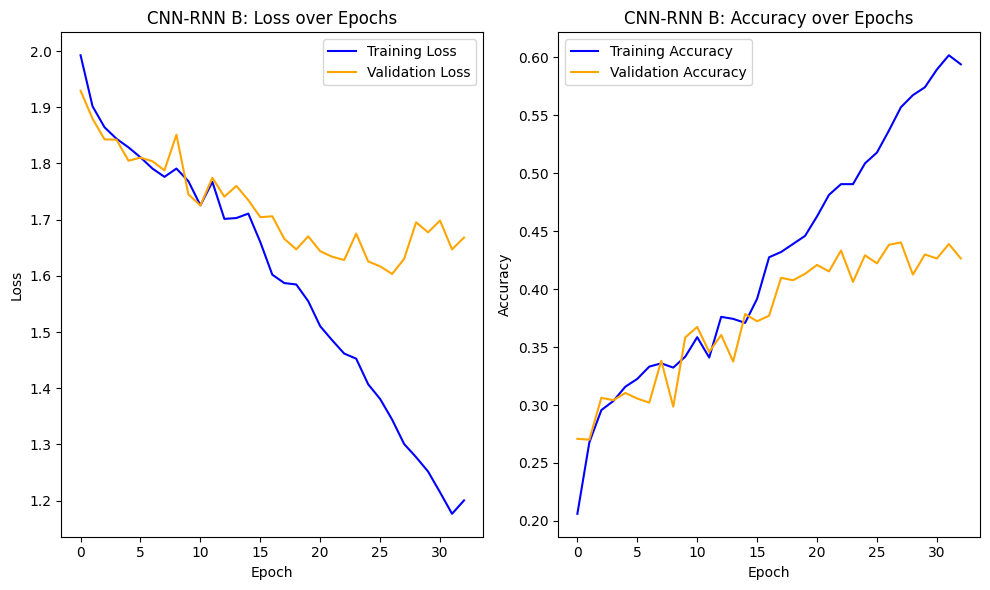

In [34]:
# plot loss and accuracy for training and val sets
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# loss plot
axs[0].plot(hyb_b_hist.history['loss'], label='Training Loss', color='blue')
axs[0].plot(hyb_b_hist.history['val_loss'], label='Validation Loss', color='orange')
axs[0].set_title('CNN-RNN B: Loss over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# acc plot
axs[1].plot(hyb_b_hist.history['accuracy'], label='Training Accuracy', color='blue')
axs[1].plot(hyb_b_hist.history['val_accuracy'], label='Validation Accuracy', color='orange')
axs[1].set_title('CNN-RNN B: Accuracy over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

It improved with those latest updates. This is a tricky balance now; I will try both increasing the complexity of the model but also making the regularization penalty a little more severe.

In [30]:
# hybrid cnn-rnn b
num_classes = y_train.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2], 1)


hyb_c = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape)
        # first cnn cycle
        , layers.Conv2D(32, kernel_size=(7, 7), kernel_regularizer = regularizers.l2(1e-4), padding= 'same')
        , layers.LeakyReLU()
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.3)

        # second cnn cycle
        , layers.Conv2D(64, kernel_size=(5, 5), kernel_regularizer = regularizers.l2(1e-4), padding= 'same')
        , layers.LeakyReLU()
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.3)

        # third cnn cycle
        , layers.Conv2D(128, kernel_size=(3, 3), kernel_regularizer = regularizers.l2(1e-4), padding= 'same')
        , layers.LeakyReLU()
        , layers.MaxPooling2D(pool_size=(2, 2))
        , layers.Dropout(0.3)


        # flatten frequency and channel dimensions, preserve time
        # had ChatGPT help me with this part
        , layers.Reshape((161, -1))

        # rnn layers
        , layers.LSTM(64, return_sequences = False)   # only care about the last output
        , layers.Dropout(0.3)

        # output layers
        , layers.Dense(num_classes, activation="softmax")
    ]
)

hyb_c.summary()

# set training hyperparameters
batch_size = 64
epochs = 100

# set optimizer
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss"
    , patience = 6                    # stop if val loss doesn't improve after 6 epochs
    , restore_best_weights = True
)

# compile
hyb_c.compile(
    loss="categorical_crossentropy"
    , optimizer=opt
    , metrics=["accuracy"]
)

# fit
hyb_c_hist = hyb_c.fit(
    X_train
    , y_train
    , batch_size = batch_size
    , epochs = epochs
    , validation_split = 0.2
    , callbacks = [early_stopping]
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 128, 1291, 32)  │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128, 1291, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 645, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 645, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 645, 64)    │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 64, 645, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 322, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 322, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 322, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 322, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 161, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 161, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 161, 2048)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,168 (2.55 MB)

 Trainable params: 668,168 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 339ms/step - accuracy: 0.1436 - loss: 2.0769 - val_accuracy: 0.1924 - val_loss: 2.0402
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 323ms/step - accuracy: 0.2129 - loss: 1.9941 - val_accuracy: 0.2403 - val_loss: 1.9716
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 322ms/step - accuracy: 0.2492 - loss: 1.9471 - val_accuracy: 0.2639 - val_loss: 1.9603
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 323ms/step - accuracy: 0.2584 - loss: 1.9299 - val_accuracy: 0.2799 - val_loss: 1.9246
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 323ms/step - accuracy: 0.2894 - loss: 1.8900 - val_accuracy: 0.2833 - val_loss: 1.9117
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 323ms/step - accuracy: 0.2999 - loss: 1.8693 - val_accuracy: 0.2715 - val_loss: 1.9046
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 323ms/step - accuracy: 0.3127 - loss: 1.8438 - val_accuracy: 0.2681 - val_loss: 1.8963
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 323ms/step - accuracy: 0.3135 - loss: 1.8246 - 

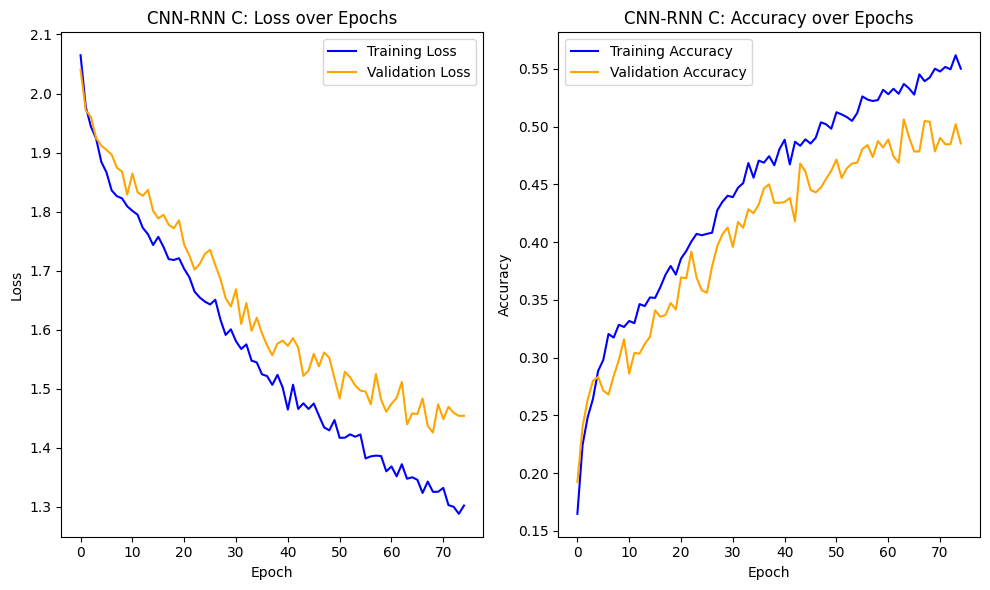

In [31]:
# plot loss and accuracy for training and val sets
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# loss plot
axs[0].plot(hyb_c_hist.history['loss'], label='Training Loss', color='blue')
axs[0].plot(hyb_c_hist.history['val_loss'], label='Validation Loss', color='orange')
axs[0].set_title('CNN-RNN C: Loss over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# acc plot
axs[1].plot(hyb_c_hist.history['accuracy'], label='Training Accuracy', color='blue')
axs[1].plot(hyb_c_hist.history['val_accuracy'], label='Validation Accuracy', color='orange')
axs[1].set_title('CNN-RNN C: Accuracy over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

Validation accuracy above 50%, our best so far! By loosening the early stopping criteria and increasing the number of epochs we might get some better results but I don't think they would be that impactful; the training accuracy seems to be increasing at a lower rate as we get farther into the epochs.

In [32]:
# save hyb_c to google drive
with open('/content/drive/MyDrive/DTSA5511_Final/hyb_c.pkl', 'wb') as f:
    pickle.dump(hyb_c, f)



### The last modeling approach will consider asymmetric convolution kernels
I should have thought of this sooner. The spectrogram considers frequency on the y-axis and time of the x-axis. There's not much of a reason to consider these on the same scale. The standard square kernels used in CNNs are good at picking up spatial detail in images, but our images are a little different. Let's see if we can get any frequency or time based details to emerge with this approach.

In [30]:
# asymmetric model a
num_classes = y_train.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2], 1)

asy_a = tf.keras.Sequential([
    tf.keras.Input(shape=(128, 1291, 1)),  # (mel bins, time frames, channel)

    # time pattern details
    layers.Conv2D(32, kernel_size=(1, 7), padding='same')
    , layers.LeakyReLU()
    , layers.MaxPooling2D(pool_size=(1, 3))

    # freq feature details
    , layers.Conv2D(32, kernel_size=(7, 1), padding='same')
    , layers.LeakyReLU()
    , layers.MaxPooling2D(pool_size=(2, 1))

    # time-freq combo details
    , layers.Conv2D(32, kernel_size=(3, 3), padding='same')
    , layers.LeakyReLU()
    , layers.MaxPooling2D(pool_size=(2, 2))

    , layers.Flatten()
    #, layers.Dense(128)   # add a dense layer for extra complexity
    #, layers.Dropout(0.3)
    , layers.Dense(num_classes, activation='softmax')
])

asy_a.summary()

# set training hyperparameters
batch_size = 64
epochs = 60

# set optimizer
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)

# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss"
    , patience = 6                    # stop if val loss doesn't improve after 6 epochs
    , restore_best_weights = True
)

# compile
asy_a.compile(
    loss="categorical_crossentropy"
    , optimizer=opt
    , metrics=["accuracy"]
)

# fit
asy_a_hist = asy_a.fit(
    X_train
    , y_train
    , batch_size = batch_size
    , epochs = epochs
    , validation_split = 0.2
    , callbacks = [early_stopping]
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 128, 1291, 32)  │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128, 1291, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 430, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 430, 32)   │         7,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 128, 430, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 430, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 430, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64, 430, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 215, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 220160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │     1,761,288 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,777,992 (6.78 MB)

 Trainable params: 1,777,992 (6.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.2126 - loss: 2.1362 - val_accuracy: 0.3708 - val_loss: 1.7074
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.4022 - loss: 1.6267 - val_accuracy: 0.4313 - val_loss: 1.6015
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - accuracy: 0.5280 - loss: 1.3834 - val_accuracy: 0.4431 - val_loss: 1.5391
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - accuracy: 0.5954 - loss: 1.2161 - val_accuracy: 0.4229 - val_loss: 1.6040
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - accuracy: 0.7017 - loss: 0.9421 - val_accuracy: 0.4368 - val_loss: 1.6029
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - accuracy: 0.8005 - loss: 0.6967 - val_accuracy: 0.4549 - val_loss: 1.6712
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.8950 - loss: 0.4159 - val_accuracy: 0.4306 - val_loss: 1.8243
Epoch 8/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - accuracy: 0.9592 - loss: 0.2223 - val_accu

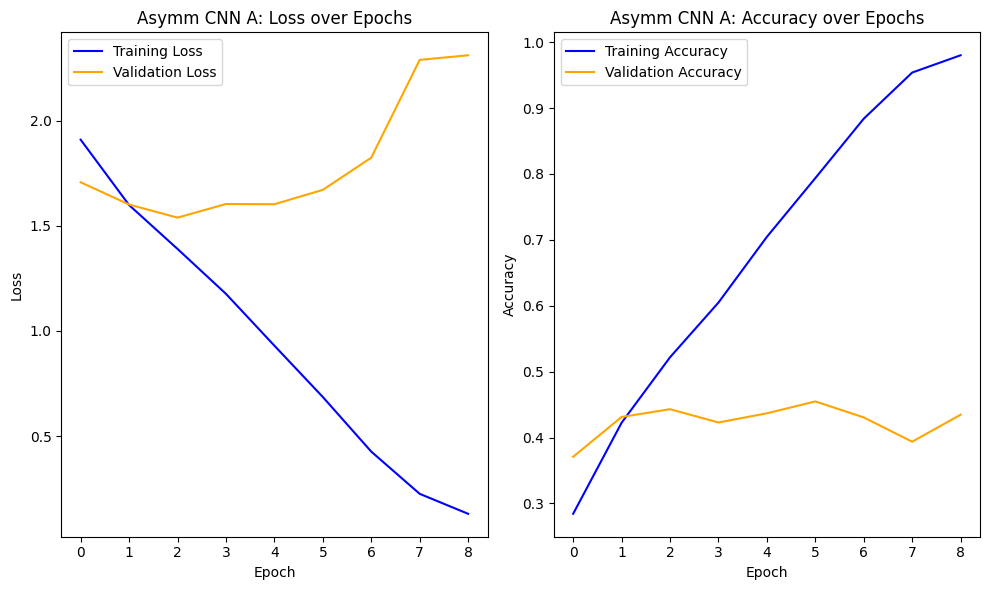

In [31]:
# plot loss and accuracy for training and val sets
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# loss plot
axs[0].plot(asy_a_hist.history['loss'], label='Training Loss', color='blue')
axs[0].plot(asy_a_hist.history['val_loss'], label='Validation Loss', color='orange')
axs[0].set_title('Asymm CNN A: Loss over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# acc plot
axs[1].plot(asy_a_hist.history['accuracy'], label='Training Accuracy', color='blue')
axs[1].plot(asy_a_hist.history['val_accuracy'], label='Validation Accuracy', color='orange')
axs[1].set_title('Asymm CNN A: Accuracy over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

Another classic overfitting curve; the training loss and accuracy look great but the validation set metrics get worse or plateau quickly. Let's introduce some more regularization.

In [34]:
# asymm b

asy_b = tf.keras.Sequential([
    tf.keras.Input(shape=(128, 1291, 1)),  # (mel bins, time frames, channel)

    # time pattern details
    layers.Conv2D(16, kernel_size=(1, 7), kernel_regularizer = regularizers.l2(1e-3), padding='same')
    , layers.LeakyReLU()
    , layers.MaxPooling2D(pool_size=(1, 3))

    # freq feature details
    , layers.Conv2D(16, kernel_size=(7, 1), kernel_regularizer = regularizers.l2(1e-3), padding='same')
    , layers.LeakyReLU()
    , layers.MaxPooling2D(pool_size=(2, 1))

    # time-freq combo details
    , layers.Conv2D(32, kernel_size=(3, 3), kernel_regularizer = regularizers.l2(1e-3), padding='same')
    , layers.LeakyReLU()
    , layers.MaxPooling2D(pool_size=(2, 2))

    , layers.Flatten()
    , layers.Dense(num_classes, activation='softmax')
])

asy_b.summary()

# set training hyperparameters
batch_size = 64
epochs = 60

# set optimizer
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)

# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss"
    , patience = 4                    # stop if val loss doesn't improve after 4 epochs
    , restore_best_weights = True
)

# compile
asy_b.compile(
    loss="categorical_crossentropy"
    , optimizer=opt
    , metrics=["accuracy"]
)

# fit
asy_b_hist = asy_b.fit(
    X_train
    , y_train
    , batch_size = batch_size
    , epochs = epochs
    , validation_split = 0.2
    , callbacks = [early_stopping]
)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 128, 1291, 16)  │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 128, 1291, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 128, 430, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 430, 16)   │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 128, 430, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 64, 430, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 430, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 64, 430, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 32, 215, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 220160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │     1,761,288 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,767,864 (6.74 MB)

 Trainable params: 1,767,864 (6.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - accuracy: 0.2404 - loss: 2.1656 - val_accuracy: 0.3812 - val_loss: 1.7105
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.4484 - loss: 1.6341 - val_accuracy: 0.4229 - val_loss: 1.6395
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.4853 - loss: 1.4970 - val_accuracy: 0.4417 - val_loss: 1.5724
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.5934 - loss: 1.2812 - val_accuracy: 0.4174 - val_loss: 1.6809
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.6565 - loss: 1.1087 - val_accuracy: 0.4792 - val_loss: 1.5259
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.7542 - loss: 0.8658 - val_accuracy: 0.4493 - val_loss: 1.6442
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.8407 - loss: 0.6448 - val_accuracy: 0.4556 - val_loss: 1.7008
Epoch 8/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.9058 - loss: 0.4567 - val_accu

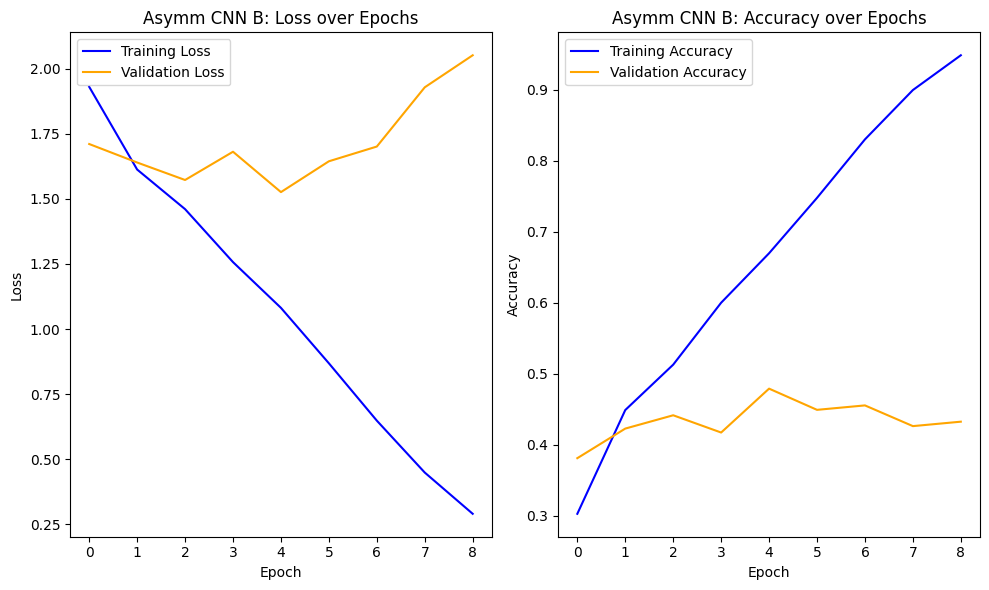

In [35]:
# plot loss and accuracy for training and val sets
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# loss plot
axs[0].plot(asy_b_hist.history['loss'], label='Training Loss', color='blue')
axs[0].plot(asy_b_hist.history['val_loss'], label='Validation Loss', color='orange')
axs[0].set_title('Asymm CNN B: Loss over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# acc plot
axs[1].plot(asy_b_hist.history['accuracy'], label='Training Accuracy', color='blue')
axs[1].plot(asy_b_hist.history['val_accuracy'], label='Validation Accuracy', color='orange')
axs[1].set_title('Asymm CNN B: Accuracy over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

Again, the training metrics look really good. I'm going to reduce model complexity and learning rate for the next run.

In [44]:
# asymm c

asy_c = tf.keras.Sequential([
    tf.keras.Input(shape=(128, 1291, 1)),  # (mel bins, time frames, channel)

    # time pattern details
    layers.Conv2D(16, kernel_size=(1, 7), kernel_regularizer = regularizers.l2(5e-3), padding='same')
    , layers.LeakyReLU()
    , layers.MaxPooling2D(pool_size=(1, 3))
    #, layers.Dropout(0.3)

    # freq feature details
    , layers.Conv2D(16, kernel_size=(7, 1), kernel_regularizer = regularizers.l2(5e-3), padding='same')
    , layers.LeakyReLU()
    , layers.MaxPooling2D(pool_size=(2, 1))
    #, layers.Dropout(0.3)

    # time-freq combo details
    , layers.Conv2D(32, kernel_size=(3, 3), kernel_regularizer = regularizers.l2(5e-3), padding='same')
    , layers.LeakyReLU()
    , layers.MaxPooling2D(pool_size=(2, 2))
    , layers.Dropout(0.3)

    , layers.Flatten()
    , layers.Dense(num_classes, activation='softmax')
])

asy_c.summary()

# set training hyperparameters
batch_size = 64
epochs = 60

# set optimizer
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss"
    , patience = 4                    # stop if val loss doesn't improve after 4 epochs
    , restore_best_weights = True
)

# compile
asy_c.compile(
    loss="categorical_crossentropy"
    , optimizer=opt
    , metrics=["accuracy"]
)

# fit
asy_c_hist = asy_c.fit(
    X_train
    , y_train
    , batch_size = batch_size
    , epochs = epochs
    , validation_split = 0.2
    , callbacks = [early_stopping]
)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 128, 1291, 16)  │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 128, 1291, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 128, 430, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 128, 430, 16)   │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 128, 430, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 64, 430, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 64, 430, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 64, 430, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 32, 215, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 215, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 220160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │     1,761,288 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,767,864 (6.74 MB)

 Trainable params: 1,767,864 (6.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.2206 - loss: 2.2056 - val_accuracy: 0.3799 - val_loss: 1.9677
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.3847 - loss: 1.9259 - val_accuracy: 0.3882 - val_loss: 1.8826
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.4082 - loss: 1.8264 - val_accuracy: 0.4194 - val_loss: 1.8083
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.4547 - loss: 1.7443 - val_accuracy: 0.4292 - val_loss: 1.7746
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.4764 - loss: 1.6926 - val_accuracy: 0.4458 - val_loss: 1.7526
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.5005 - loss: 1.6333 - val_accuracy: 0.4368 - val_loss: 1.7533
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.5162 - loss: 1.5875 - val_accuracy: 0.4556 - val_loss: 1.7042
Epoch 8/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.5430 - loss: 1.5453 - val_accu

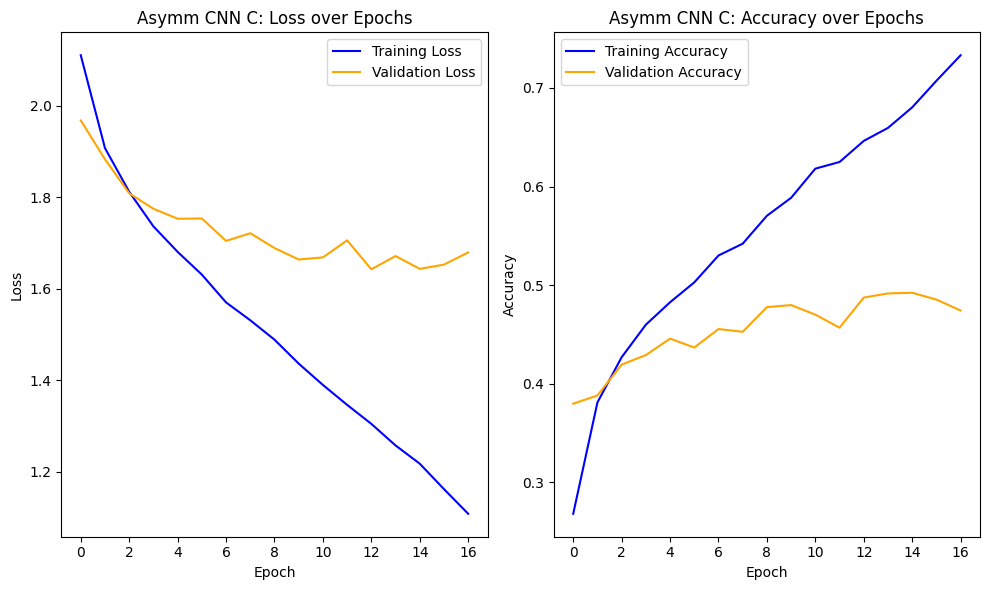

In [45]:
# plot loss and accuracy for training and val sets
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# loss plot
axs[0].plot(asy_c_hist.history['loss'], label='Training Loss', color='blue')
axs[0].plot(asy_c_hist.history['val_loss'], label='Validation Loss', color='orange')
axs[0].set_title('Asymm CNN C: Loss over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# acc plot
axs[1].plot(asy_c_hist.history['accuracy'], label='Training Accuracy', color='blue')
axs[1].plot(asy_c_hist.history['val_accuracy'], label='Validation Accuracy', color='orange')
axs[1].set_title('Asymm CNN C: Accuracy over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

Looks like we hit a wall again. The traing set continues to improve but our validation plateaus.

## Results and Analysis
Overall I find the validation results underwhelming. I often quickly found the models overfitting. After introducing some regularization, the training metrics suffered. It was difficult to balance model complexity with generalization.

In [33]:
# results for plotting
results = pd.DataFrame({
    'Model': ['CNN A', 'CNN B', 'CNN C', 'CNN-RNN A', 'CNN-RNN B', 'CNN-RNN C', 'Asymm CNN A', 'Asymm CNN B', 'Asymm CNN C']
    , 'Validation Loss': [1.5757, 1.6242, 1.5503, 1.7927, 1.6034, 1.4254, 1.6029, 1.5259, 1.6422]
    , 'Validation Accuracy': [0.4451, 0.4194, 0.4368, 0.3340, 0.4382, 0.5042, 0.4368, 0.4792, 0.4875]
})


### Results Table
| Model         | Validation Loss | Validation Accuracy |
|---------------|------------------|----------------------|
| CNN A         | 1.5757           | 0.4451               |
| CNN B         | 1.6242           | 0.4194               |
| CNN C         | 1.5503           | 0.4368               |
| CNN-RNN A     | 1.7927           | 0.3340               |
| CNN-RNN B     | 1.6034           | 0.4382               |
| CNN-RNN C     | 1.4254           | 0.5042               |
| Asymm CNN A   | 1.6029           | 0.4368               |
| Asymm CNN B   | 1.5259           | 0.4792               |
| Asymm CNN C   | 1.6422           | 0.4875               |

### Results Charts

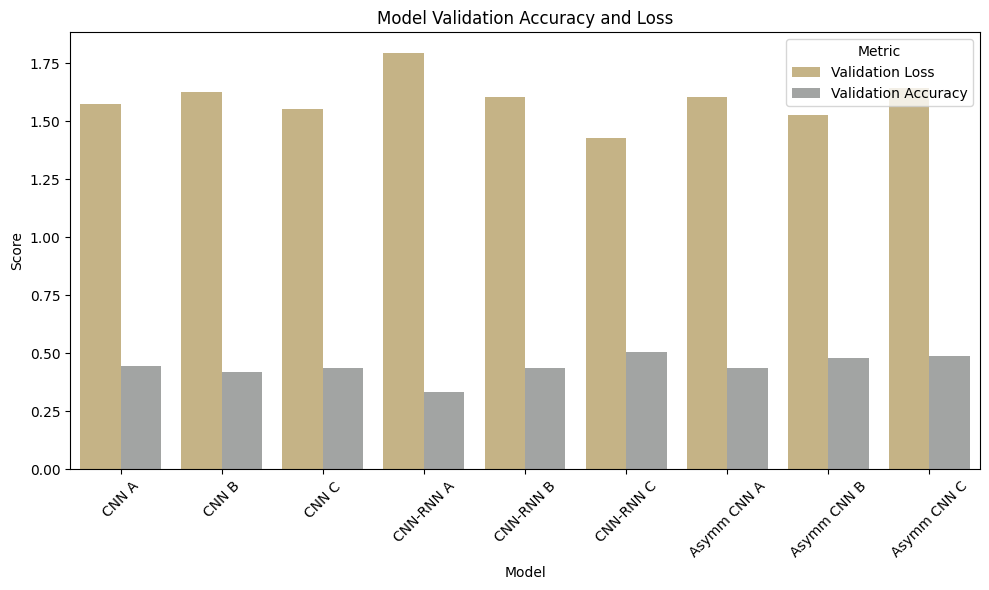

In [37]:
# sns barchart of results

# melt to get in better format for plotting
results_melted = results.melt(
    id_vars = 'Model',
    value_vars = ['Validation Loss', 'Validation Accuracy'],
    var_name = 'Metric',
    value_name = 'Value'
)

# colors
colors = {
    'Validation Loss': '#CFB87C',
    'Validation Accuracy': '#A2A4A3'
}

# Create grouped barplot
plt.figure(figsize = (10, 6))
sns.barplot(
    data = results_melted
    , x = "Model"
    , y = "Value"
    , hue = "Metric"
    , palette = colors
)

# Format plot
plt.title("Model Validation Accuracy and Loss")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.tight_layout()
plt.show()



### The best model is CNN-RNN C

A good way to determine the better model is by looking at the model loss. We can get a sense of how confident the model predictions are using loss. CNN-RNN C shows the lowest loss, so it was the most 'confident' in making the accurate predictions on the validation set. I think CNN-RNN C performed the best because it was the most complex of the models combining the CNN and RNN strategies in combination.  
  
I will create a prediction set using the CNN-RNN A model; we can then review the confusion matrix for predictions to see how well the different genres get predicted.  
  


In [55]:
# load the pickled model
#with open('/content/drive/MyDrive/DTSA5511_Final/hyb_c.pkl', 'rb') as f:
    #hyb_c = pickle.load(f)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

----------------------------
Accuracy: 0.505


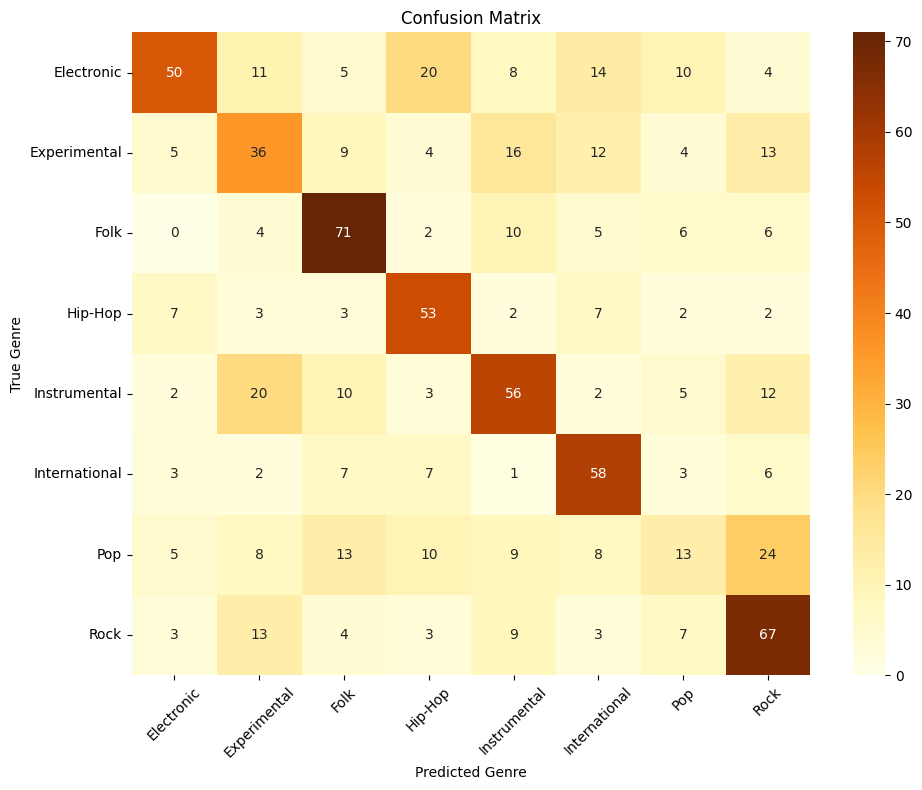

In [57]:
# make predictions on
y_pred = np.argmax(hyb_c.predict(X_test), axis=1)
y_test_labels = np.argmax(y_test, axis=1)  # rename to avoid overwriting original

# print the accuracy
print()
print('----------------------------')
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred)}")


# recover the genre names from the one hot encoding
genre_names = pd.get_dummies(tracks[('track', 'genre_top')]).columns.tolist()

# confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# make it pretty
plt.figure(figsize = (10, 8))
sns.heatmap(
    cm
    , annot = True
    , fmt = 'd'
    , cmap = 'YlOrBr'
    , xticklabels = genre_names
    , yticklabels = genre_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

After making predictions, we calculate an Accuracy of 0.505. That doesn't sound great, and it's not, but remember we're dealing with a multiclass prediction so a 0.505 here is **much** better than when considering a binary class accuracy  
  
Reviewing the confusion matrix gives us more information. The CNN-RNN C model picked the correct class more often than not for six of the eight class; the two exceptions being Experimental and Pop.  
  
Most common misidentifications were actual Pop songs being identified as Rock (24), actual Instrumental songs being identified as Experimental (20), and actual Electronic songs being identified as Hip-Hop (20). If you think about the characteristics of those genres, it's reasonable how given only a 30 second sample, even a human listener might misidentify those songs.

## Conclusion
I began this project not knowing much about music, being that I don't play any, and am just a casual fan. I needed to learn quite a bit of detail about the technical elements of how modern digital music gets stored.  The mel spectrograms involved can be used to dissect and analyze music and other sounds in amazing ways.  
  
More importantly, I learned a great deal about the project pipeline of implementing a deep learning model. Understanding how deep learning and neural networks work constitutes only the beginning. A great deal needs to be known about the relative strengths and weaknesses of different architectures and the components of those architectures; and I feel like I've only scratched the surface. Even with a fuller understanding, I feel like the best models also involve a great deal of trial and error and access to impressive technology.  
  
Sadly, I felt a little underwhelmed with the accuracy of my models, although I thought the approaches seemed sound (no pun intended). Combining the 2D spatial advantages of a CNN with the temporal and sequence related advantages of an RNN seemed like a natural fit for images that basically are tracking the visual equivalent of a sound over time. And it is where I got the best results. However, I also feel like a more traditional CNN approach with the asymmetric kernels also shows a lot of promise.  
  
If I was starting over I would do a couple things differently. I wouldn't spend as much time on CNNs as we already know what they do well. Instead I would dig deeper into different asymmetric kernel configurations and max value smoothing kernel sizes. I would also try different representations of the mel spectrogram. I stuck with my initial processing parameters but those too could be adjusted; we could evaluate more or less frequency information per second, and that could change our results a lot.  So, any future work of mine would be focused on altering the mel spectrogram representations and exploring different asymmetric kernel dimensions.
  


In [ ]:
## Conclusion


keep going
